# 物体检测

识别所有的感兴趣的物体和位置

边缘框：
- 四个数字定义
    - 左上坐标，右下坐标
    - 左上坐标，宽高
    
目标检测数据集：
- [COCO](http://cocodataset.org) 数据集
    - 80物体，330k图片，1.5M个物体

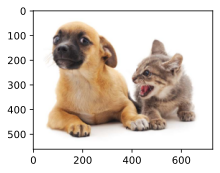

In [9]:
%matplotlib inline
import torch
from PIL import Image
from matplotlib import pyplot as plt
from matplotlib_inline import backend_inline
import os

backend_inline.set_matplotlib_formats('svg')
plt.rcParams["figure.figsize"] = (3.5, 2.5)
img = Image.open(os.path.join('.', 'img', 'catdog.jpg'))
plt.imshow(img)
plt.show()

In [6]:
def box_corner_to_center(boxes):
    """从（左上，右下）转换到（中间，宽度，高度）"""
    x1, y1, x2, y2 = boxes[:, 0], boxes[:, 1], boxes[:, 2], boxes[:, 3]
    cx = (x1 + x2) / 2
    cy = (y1 + y2) / 2
    w = x2 - x1
    h = y2 - y1
    boxes = torch.stack((cx, cy, w, h), axis=-1)
    return boxes

def box_center_to_corner(boxes):
    """从（中间，宽度，高度）转换到（左上，右下）"""
    cx, cy, w, h = boxes[:, 0], boxes[:, 1], boxes[:, 2], boxes[:, 3]
    x1 = cx - 0.5 * w
    y1 = cy - 0.5 * h
    x2 = cx + 0.5 * w
    y2 = cy + 0.5 * h
    boxes = torch.stack((x1, y1, x2, y2), axis=-1)
    return boxes

In [7]:
# 猫猫狗狗的框
dog_bbox, cat_bbox = [60.0, 45.0, 378.0, 516.0], [400.0, 112.0, 655.0, 493.0]
boxes = torch.tensor((dog_bbox, cat_bbox))
box_center_to_corner(box_corner_to_center(boxes)) == boxes, boxes.shape

(tensor([[True, True, True, True],
         [True, True, True, True]]),
 torch.Size([2, 4]))

In [16]:
def bbox_to_rect(axes, bbox, color, text):
    xy = (bbox[0], bbox[1])
    # 左上 高 宽
    axes.add_patch(plt.Rectangle(xy, width=bbox[2] - bbox[0], 
                         height=bbox[3]-bbox[1], fill=False,
                         edgecolor=color, linewidth=2))
    axes.text(bbox[0], bbox[1], text, bbox={'facecolor':color, 'alpha':0.5})
            

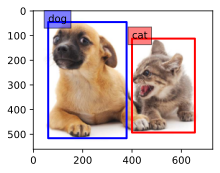

In [17]:
plt.imshow(img)
axe = plt.gca()
bbox_to_rect(axe, dog_bbox, 'blue', 'dog')
bbox_to_rect(axe, cat_bbox, 'red', 'cat')

# 数据集

In [24]:
import os
import torchvision
import pandas as pd
from d2l import torch as d2l

d2l.DATA_HUB['banana-detection'] = (
    d2l.DATA_URL + 'banana-detection.zip',
    '5de26c8fce5ccdea9f91267273464dc968d20d72')

In [25]:
def read_data_bananas(is_train=True):
    """读取香蕉检测数据集中的图像和标签。"""
    data_dir = d2l.download_extract('banana-detection')
    csv_fname = os.path.join(data_dir,
                             'bananas_train' if is_train else 'bananas_val',
                             'label.csv')
    csv_data = pd.read_csv(csv_fname)
    csv_data = csv_data.set_index('img_name')
    images, targets = [], []
    for img_name, target in csv_data.iterrows():
        images.append(
            torchvision.io.read_image(
                os.path.join(data_dir,
                             'bananas_train' if is_train else 'bananas_val',
                             'images', f'{img_name}')))
        targets.append(list(target))
    # unsqueeze 增加一个维度
    return images, torch.tensor(targets).unsqueeze(1) / 256 # 图片大小是256 存储相对位置

In [26]:
class BananasDataset(torch.utils.data.Dataset):
    """一个用于加载香蕉检测数据集的自定义数据集。"""
    def __init__(self, is_train):
        self.features, self.labels = read_data_bananas(is_train)
        print('read ' + str(len(self.features)) + (
            f' training examples' if is_train else f' validation examples'))

    def __getitem__(self, idx):
        return (self.features[idx].float(), self.labels[idx])

    def __len__(self):
        return len(self.features)

In [27]:
def load_data_bananas(batch_size):
    """加载香蕉检测数据集。"""
    train_iter = torch.utils.data.DataLoader(BananasDataset(is_train=True),
                                             batch_size, shuffle=True)
    val_iter = torch.utils.data.DataLoader(BananasDataset(is_train=False),
                                           batch_size)
    return train_iter, val_iter

In [33]:
batch_size, edge_size = 32, 256
train_iter, _ = load_data_bananas(batch_size)
batch = next(iter(train_iter))
batch[0].shape, batch[1].shape, type(batch[0])

read 1000 training examples
read 100 validation examples


(torch.Size([32, 3, 256, 256]), torch.Size([32, 1, 5]), torch.Tensor)

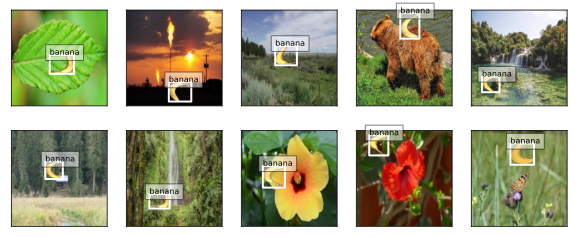

In [42]:
imgs = (batch[0][0:10].permute(0, 2, 3, 1)) / 255 # 调换维度适应matplotlib
axes = d2l.show_images(imgs, 2, 5, scale=2)
for ax, label in zip(axes, batch[1][0:10]):
    d2l.show_bboxes(ax, [label[0][1:5] * edge_size], colors=['w'])
    ax.text(label[0][1] * edge_size, label[0][2] * edge_size, 'banana', bbox={'facecolor':'w', 'alpha':0.5}, fontdict={'size':8})

# 手动标注

- Make Sense